In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [16]:
df = pd.read_csv('Dataset.csv')

print("Dataset shape:", df.shape)
print(df.head())
print(df.info())

Dataset shape: (175393, 30)
             Timestamp       SoC       SoH  Battery_Voltage  Battery_Current  \
0  2020-01-01 00:00:00  0.826099  0.941338       210.163881       -22.753095   
1  2020-01-01 00:15:00  0.064728  0.916059       364.000102       -27.701120   
2  2020-01-01 00:30:00  0.873643  0.908020       388.855089       -36.646406   
3  2020-01-01 00:45:00  0.853009  0.916476       370.570602       -37.609429   
4  2020-01-01 01:00:00  0.947540  0.913206       390.011904       -14.275808   

   Battery_Temperature  Charge_Cycles  Motor_Temperature  Motor_Vibration  \
0            27.149201     149.190930          48.496049         0.369095   
1            53.655101     171.702388          57.829492         1.449195   
2            29.559090     191.617645          46.518363         1.859045   
3            29.690283     111.881817          54.163681         0.381500   
4            28.864338     163.774377          42.075978         0.433927   

   Motor_Torque  ...  Load_W

In [18]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

corr_matrix = numeric_df.corr()

targets = ['RUL', 'Failure_Probability', 'TTF', 'Component_Health_Score']

# Print correlation of each feature with the targets
for target in targets:
    if target in corr_matrix.columns:
        print(f"\nCorrelation of features with {target}:\n")
        print(corr_matrix[target].sort_values(ascending=False))
    else:
        print(f"\nWarning: Target '{target}' not found in numeric columns!")



Correlation of features with RUL:

RUL                       1.000000
Load_Weight               0.005351
Charge_Cycles             0.004847
Distance_Traveled         0.004024
Power_Consumption         0.003383
Driving_Speed             0.003062
Brake_Pad_Wear            0.002809
Battery_Voltage           0.001432
TTF                       0.001397
Suspension_Load           0.001347
Component_Health_Score    0.001182
Failure_Probability       0.000955
SoH                       0.000747
Idle_Time                 0.000351
Ambient_Temperature       0.000202
Brake_Pressure            0.000161
SoC                      -0.000420
Motor_Temperature        -0.000662
Maintenance_Type         -0.000664
Motor_RPM                -0.000680
Battery_Current          -0.000696
Tire_Pressure            -0.000763
Motor_Vibration          -0.001678
Reg_Brake_Efficiency     -0.002011
Motor_Torque             -0.002351
Ambient_Humidity         -0.002983
Battery_Temperature      -0.003068
Tire_Temperature   

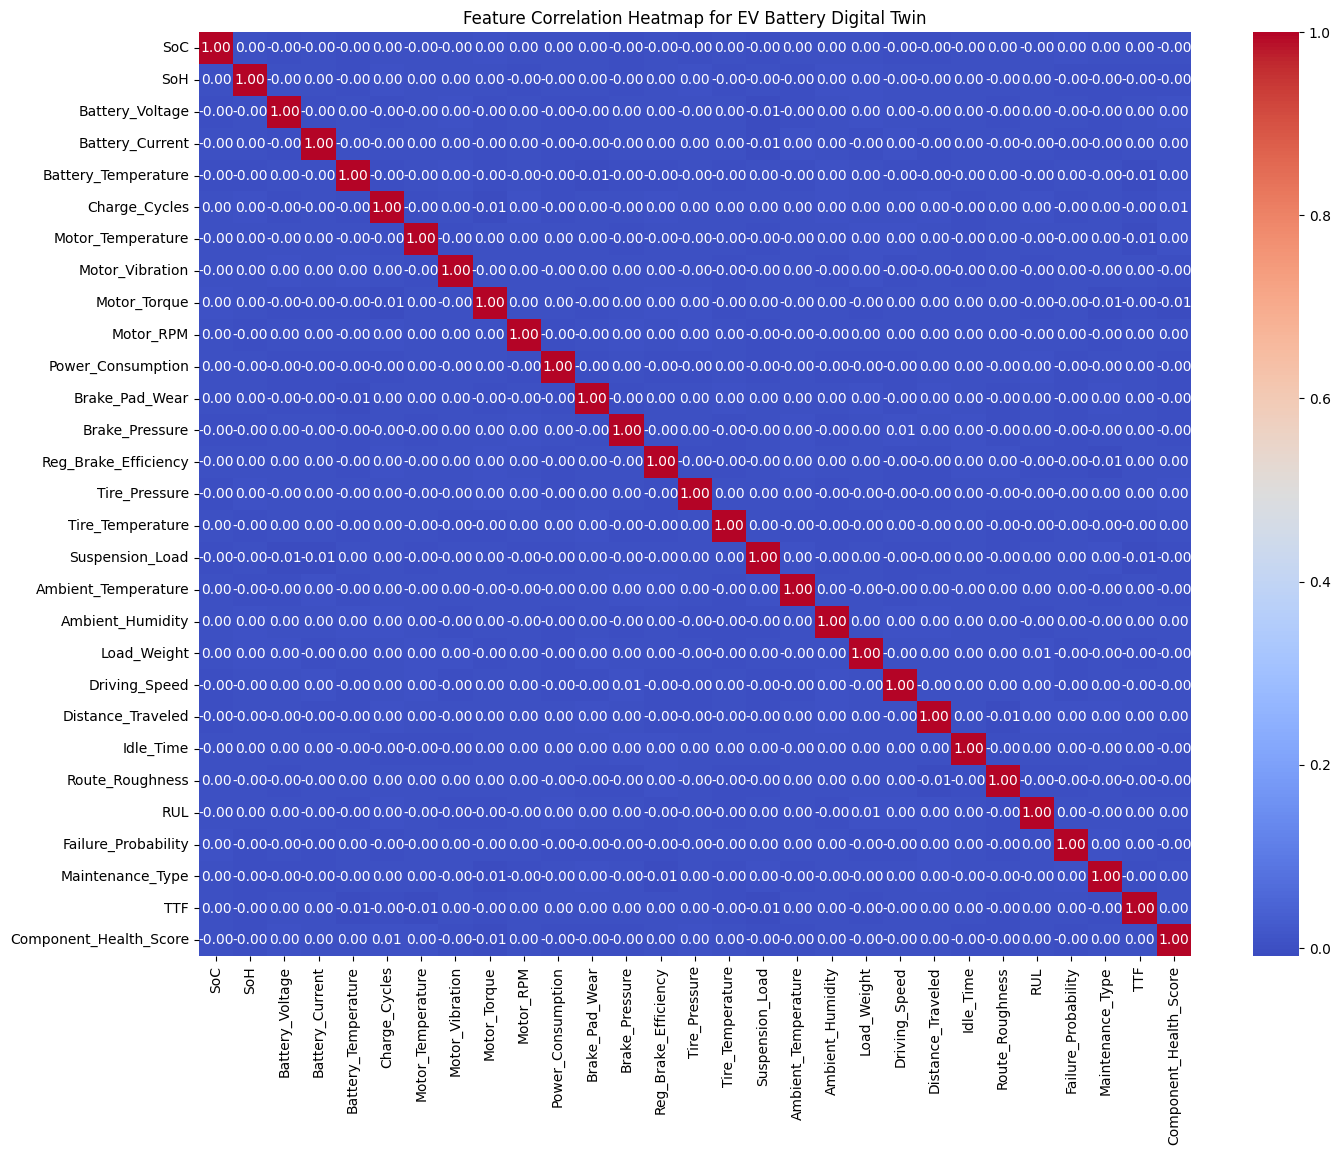

In [19]:
plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap for EV Battery Digital Twin')
plt.show()

In [20]:
threshold = 0.85
high_corr_pairs = [(col1, col2, corr_matrix.loc[col1, col2])
                   for col1 in corr_matrix.columns
                   for col2 in corr_matrix.columns
                   if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > threshold]

print("\n" + "="*60)
print("Highly Correlated Feature Pairs (>|0.85|):")
print("="*60)
for col1, col2, corr in high_corr_pairs:
    print(f"{col1} and {col2} -> correlation: {corr:.2f}")


Highly Correlated Feature Pairs (>|0.85|):


In [25]:
X = numeric_df.drop(columns=targets)
feature_importances = {}

for target in targets:
    # Calculate absolute correlation with target
    importances = abs(corr_matrix[target].drop(targets)).sort_values(ascending=False)
    feature_importances[target] = importances
    print(f"\n{'='*60}")
    print(f"Top 12 Features for {target} Prediction:")
    print('='*60)
    print(importances.head(12))


Top 12 Features for RUL Prediction:
Load_Weight             0.005351
Charge_Cycles           0.004847
Route_Roughness         0.004610
Distance_Traveled       0.004024
Power_Consumption       0.003383
Tire_Temperature        0.003113
Battery_Temperature     0.003068
Driving_Speed           0.003062
Ambient_Humidity        0.002983
Brake_Pad_Wear          0.002809
Motor_Torque            0.002351
Reg_Brake_Efficiency    0.002011
Name: RUL, dtype: float64

Top 12 Features for Failure_Probability Prediction:
SoC                     0.003815
Maintenance_Type        0.003806
SoH                     0.003277
Reg_Brake_Efficiency    0.003270
Distance_Traveled       0.002870
Idle_Time               0.002842
Route_Roughness         0.002832
Battery_Current         0.002262
Brake_Pressure          0.001904
Ambient_Humidity        0.001904
Battery_Temperature     0.001866
Load_Weight             0.001677
Name: Failure_Probability, dtype: float64

Top 12 Features for TTF Prediction:
Battery_Tempe

In [26]:
combined_importance = pd.DataFrame(feature_importances)
combined_importance['Average_Importance'] = combined_importance.mean(axis=1)
combined_importance_sorted = combined_importance.sort_values('Average_Importance', ascending=False)

print("\n" + "="*60)
print("COMBINED FEATURE IMPORTANCE (All 4 Targets)")
print("="*60)
print(combined_importance_sorted)

top_12_features = combined_importance_sorted.head(12)

print("\n" + "="*60)
print("TOP 12 MOST IMPORTANT FEATURES (Combined)")
print("="*60)
print(top_12_features[['RUL', 'Failure_Probability', 'TTF', 'Component_Health_Score', 'Average_Importance']])

print("\n" + "="*60)
print("FINAL RECOMMENDATION: Use these 12 features:")
print("="*60)
for i, feature in enumerate(top_12_features.index, 1):
    print(f"{i}. {feature}")


COMBINED FEATURE IMPORTANCE (All 4 Targets)
                           RUL  Failure_Probability       TTF  \
Battery_Temperature   0.003068             0.001866  0.007337   
Charge_Cycles         0.004847             0.001631  0.001244   
Route_Roughness       0.004610             0.002832  0.001127   
Motor_Torque          0.002351             0.000983  0.001984   
Reg_Brake_Efficiency  0.002011             0.003270  0.002677   
Motor_Temperature     0.000662             0.000461  0.005736   
Load_Weight           0.005351             0.001677  0.001875   
Suspension_Load       0.001347             0.000894  0.005737   
Power_Consumption     0.003383             0.001213  0.001043   
Distance_Traveled     0.004024             0.002870  0.000099   
SoH                   0.000747             0.003277  0.001294   
Brake_Pressure        0.000161             0.001904  0.002054   
Ambient_Humidity      0.002983             0.001904  0.002390   
Maintenance_Type      0.000664             0.

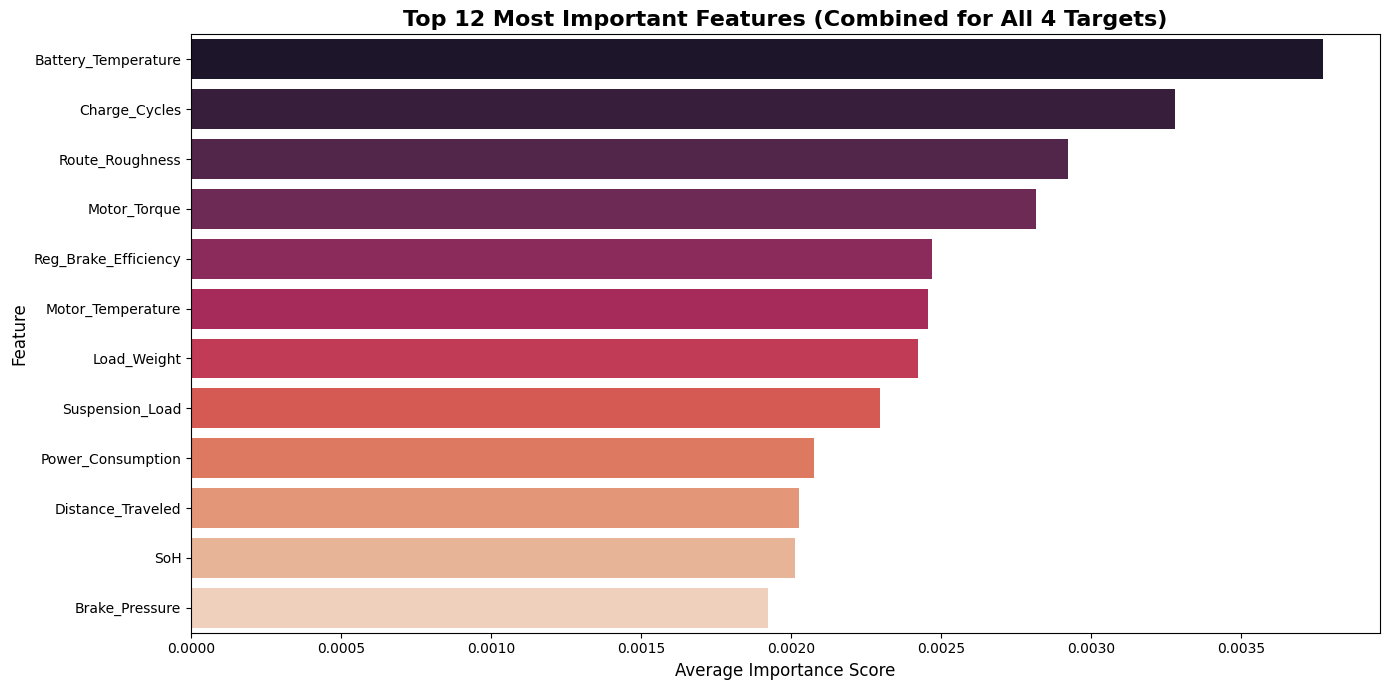

In [28]:
plt.figure(figsize=(14,7))
sns.barplot(x=top_12_features['Average_Importance'].values,
            y=top_12_features.index, palette='rocket')
plt.title('Top 12 Most Important Features (Combined for All 4 Targets)', fontsize=16, fontweight='bold')
plt.xlabel('Average Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


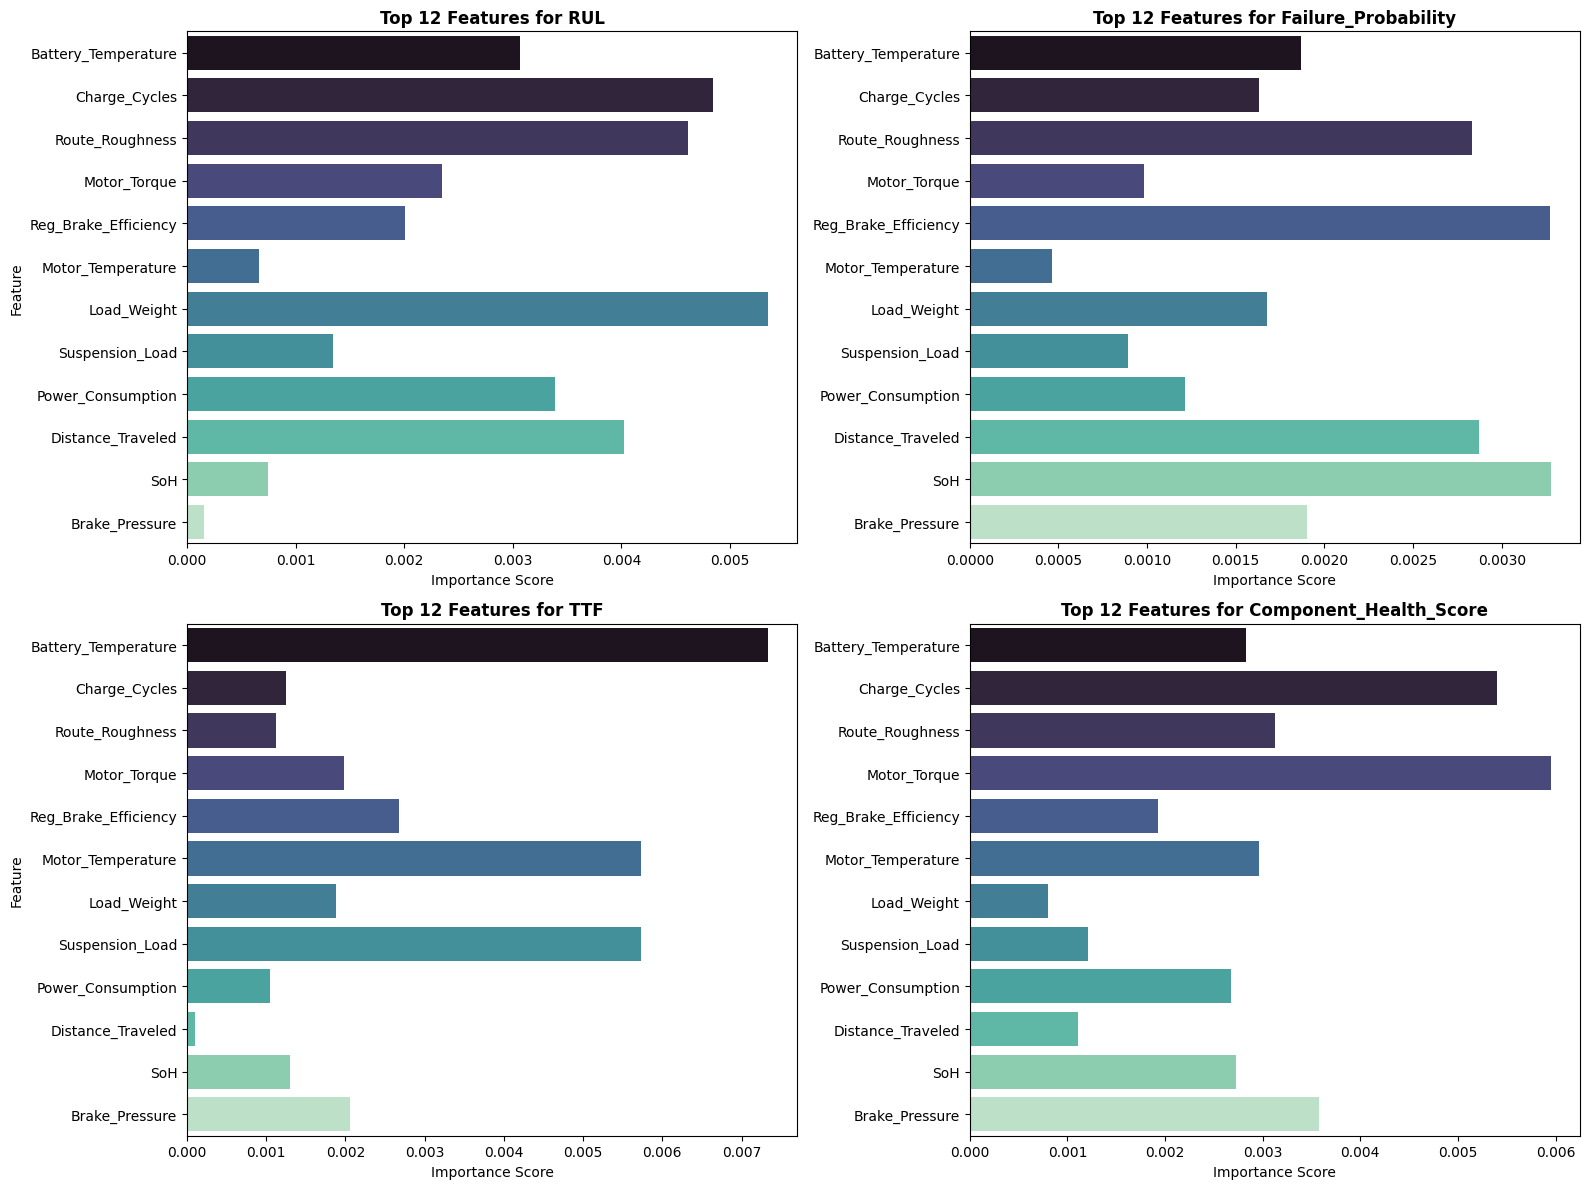


Analysis Complete!


In [29]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()
for i, target in enumerate(targets):
    sns.barplot(x=top_12_features[target].values,
                y=top_12_features.index, palette='mako', ax=axes[i])
    axes[i].set_title(f'Top 12 Features for {target}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Importance Score')
    if i % 2 == 0:
        axes[i].set_ylabel('Feature')
    else:
        axes[i].set_ylabel('')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Analysis Complete!")
print("="*60)

In [30]:
# List of top 12 features
top_12_features_list = [
    'Battery_Temperature',
    'Charge_Cycles',
    'Route_Roughness',
    'Motor_Torque',
    'Reg_Brake_Efficiency',
    'Motor_Temperature',
    'Load_Weight',
    'Suspension_Load',
    'Power_Consumption',
    'Distance_Traveled',
    'SoH',
    'Brake_Pressure'
]

# Target columns
targets = ['RUL', 'Failure_Probability', 'TTF', 'Component_Health_Score']

# Create a new DataFrame with selected features and targets
df_enhanced = df[top_12_features_list + targets]

# Save the new DataFrame to a CSV file
df_enhanced.to_csv('Dataset_Enhanced.csv', index=False)

print("Dataset_Enhanced.csv created successfully with the top 12 features and targets.")

Dataset_Enhanced.csv created successfully with the top 12 features and targets.
